In [20]:
# ==========================================
# Cell 1 — Setup and Imports
# ==========================================
# Purpose:
# - Import core libraries
# - Configure plotting
# - Enable optional XGBoost if installed

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_recall_fscore_support, confusion_matrix,
    roc_curve, auc, precision_recall_curve, average_precision_score
)

# Regressors
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Classifiers
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

# Optional unsupervised baselines
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.optimize import linear_sum_assignment

# Optional XGBoost
try:
    from xgboost import XGBRegressor, XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# Matplotlib defaults (no custom color/style to keep compatibility)
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["figure.dpi"] = 120


In [42]:
# ==========================================
# Cell 2 — Configuration
# ==========================================
# Set your CSV path. The file must include:
#   sample_id, catalog_content, image_link, price
DATA_PATH = "./train.csv"   # <-- change this
OUTDIR = "results_nb"                 # output directory for tables/plots

os.makedirs(OUTDIR, exist_ok=True)


In [43]:
# ==========================================
# Cell 3 — Load Data
# ==========================================
# Purpose:
# - Read CSV
# - Basic validation and cleaning

def load_data(path):
    df = pd.read_csv(DATA_PATH)
    expected = {"sample_id", "catalog_content", "image_link", "price"}
    missing = expected - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # Keep only rows with non-null text and price
    df = df.dropna(subset=["catalog_content", "price"]).copy()
    df["catalog_content"] = df["catalog_content"].astype(str)
    df["price"] = pd.to_numeric(df["price"], errors="coerce")
    df = df.dropna(subset=["price"])
    return df

df = load_data(DATA_PATH)
df.head()


,sample_id,catalog_content,image_link,price
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89
1,198967,"Item Name: Salerno Cookies, The Original Butte...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49


In [23]:
# ==========================================
# Cell 4 — Create 3-Class Target via Quantile Binning
# ==========================================
# Classes:
#   0 = Budget   (lower 33%)
#   1 = Mid-Range (middle 33%)
#   2 = Premium  (upper 33%)

def add_price_class(df, labels=(0, 1, 2)):
    df = df.copy()
    df["price_class"] = pd.qcut(df["price"], q=3, labels=labels)
    df["price_class"] = df["price_class"].astype(int)
    return df

df = add_price_class(df)
df[["price", "price_class"]].head(10)


,price,price_class
0,5.990,0
1,34.570,2
2,24.990,2
3,16.990,1
4,213.260,2
5,7.550,0
6,5.785,0
7,18.280,1
8,4.790,0
9,17.490,1


In [24]:
# ==========================================
# Cell 6 — Feature Pipelines (TF-IDF)
# ==========================================
# Separate feature pipelines for regression and classification.
# TF-IDF on catalog_content with 1–2 grams and a large vocabulary cap.

def get_feature_pipeline_regression():
    text_pipe = Pipeline([
        ("tfidf", TfidfVectorizer(
            lowercase=True,
            max_features=100_000,
            ngram_range=(1, 2),
            min_df=2
        ))
    ])
    coltf = ColumnTransformer(
        transformers=[("text", text_pipe, "catalog_content")],
        remainder="drop"
    )
    return coltf

def get_feature_pipeline_classification():
    text_pipe = Pipeline([
        ("tfidf", TfidfVectorizer(
            lowercase=True,
            max_features=100_000,
            ngram_range=(1, 2),
            min_df=2
        ))
    ])
    coltf = ColumnTransformer(
        transformers=[("text", text_pipe, "catalog_content")],
        remainder="drop"
    )
    return coltf

features_reg = get_feature_pipeline_regression()
features_clf = get_feature_pipeline_classification()


In [25]:
# ==========================================
# Cell 5 — Train/Test Split
# ==========================================
# For regression: standard split
# For classification: stratified to preserve class proportions

X_text = df[["catalog_content"]]
y_reg = df["price"].values
y_clf = df["price_class"].values

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_text, y_reg, test_size=0.2, random_state=42
)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_text, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

len(X_train_reg), len(X_test_reg), np.bincount(y_train_clf)


(800, 200, array([270, 263, 267]))

In [26]:
# ==========================================
# Cell 6A — Embeddings Cache Configuration
# ==========================================
# We will precompute TF-IDF embeddings ONCE per split and cache to disk.
# This avoids refitting TF-IDF for every model and speeds up experiments.

from pathlib import Path
from scipy import sparse
import joblib

CACHE_DIR = Path(OUTDIR) / "embed_cache"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Cache file paths (separate caches for regression and classification splits)
REG_VECT_PATH   = CACHE_DIR / "tfidf_vectorizer_reg.pkl"
REG_XTR_PATH    = CACHE_DIR / "X_train_reg_csr.npz"
REG_XTE_PATH    = CACHE_DIR / "X_test_reg_csr.npz"

CLF_VECT_PATH   = CACHE_DIR / "tfidf_vectorizer_clf.pkl"
CLF_XTR_PATH    = CACHE_DIR / "X_train_clf_csr.npz"
CLF_XTE_PATH    = CACHE_DIR / "X_test_clf_csr.npz"


In [27]:
# ==========================================
# Cell 6B — Build or Load TF-IDF Text Embeddings (Cached)
# ==========================================
from sklearn.feature_extraction.text import TfidfVectorizer

def fit_transform_cache_tfidf(train_text, test_text, vect_path, xtr_path, xte_path):
    if Path(vect_path).exists() and Path(xtr_path).exists() and Path(xte_path).exists():
        # Load cached
        vectorizer = joblib.load(vect_path)
        X_train = sparse.load_npz(xtr_path)
        X_test  = sparse.load_npz(xte_path)
    else:
        # Fit on TRAIN ONLY to avoid leakage; then transform both
        vectorizer = TfidfVectorizer(
            lowercase=True,
            max_features=100_000,
            ngram_range=(1, 2),
            min_df=2
        )
        X_train = vectorizer.fit_transform(train_text)
        X_test  = vectorizer.transform(test_text)

        # Persist
        joblib.dump(vectorizer, vect_path)
        sparse.save_npz(xtr_path, X_train)
        sparse.save_npz(xte_path, X_test)

    return vectorizer, X_train, X_test

# Build/load embeddings for REGRESSION split
vect_reg, X_train_reg_mat, X_test_reg_mat = fit_transform_cache_tfidf(
    X_train_reg["catalog_content"].values,
    X_test_reg["catalog_content"].values,
    REG_VECT_PATH, REG_XTR_PATH, REG_XTE_PATH
)

# Build/load embeddings for CLASSIFICATION split
vect_clf, X_train_clf_mat, X_test_clf_mat = fit_transform_cache_tfidf(
    X_train_clf["catalog_content"].values,
    X_test_clf["catalog_content"].values,
    CLF_VECT_PATH, CLF_XTR_PATH, CLF_XTE_PATH
)

X_train_reg_mat.shape, X_test_reg_mat.shape, X_train_clf_mat.shape, X_test_clf_mat.shape


((800, 15032), (200, 15032), (800, 15341), (200, 15341))

In [28]:
# ==========================================
# Cell 6C — Image Embedding Config and Setup
# ==========================================
# Purpose:
# - Configure image embedding extraction using torchvision ResNet-50
# - Set cache paths
# - Choose fusion mode: concatenate image embeddings with text TF-IDF

USE_IMAGES = True          # set False to disable image features quickly
IMG_BATCH_SIZE = 32        # adjust per GPU/CPU capacity
IMG_TIMEOUT = 10           # seconds for HTTP requests
IMG_RETRY = 1              # simple retry count for transient fetch errors

from pathlib import Path
from PIL import Image
from io import BytesIO
import requests

# Torch / Torchvision
try:
    import torch
    from torch.utils.data import Dataset, DataLoader
    import torchvision.models as models
    import torchvision.transforms as T
    TORCH_OK = True
except Exception as e:
    TORCH_OK = False
    print("Torch/torchvision not available. Install with:\n"
          "!pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu")

IMG_CACHE_DIR = Path(OUTDIR) / "img_cache"
IMG_CACHE_DIR.mkdir(parents=True, exist_ok=True)

# File mapping for per-sample cached npy embeddings
def _img_embed_path(sample_id):
    return IMG_CACHE_DIR / f"{sample_id}.npy"

# Normalization and resizing for ResNet family
if TORCH_OK:
    IMG_TRANSFORM = T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Image embedding device: {DEVICE}")


Image embedding device: cpu


In [29]:
# ==========================================
# Cell 6D — Compute/Load Image Embeddings (Cached) [FIXED]
# ==========================================
# Purpose:
# - Download images from image_link URLs
# - Extract 2048-dim embeddings from ResNet-50 (pool layer)
# - Cache per sample_id to disk to avoid recomputation
# - Return an aligned array of embeddings for given ids
# NOTE: Uses a custom collate_fn to avoid default collate on PIL images.

import numpy as np
from torch.utils.data import Dataset, DataLoader

def _safe_get_image(url, timeout=IMG_TIMEOUT, retries=IMG_RETRY):
    last_exc = None
    for _ in range(retries + 1):
        try:
            r = requests.get(url, timeout=timeout)
            if r.status_code == 200:
                return Image.open(BytesIO(r.content)).convert("RGB")
        except Exception as e:
            last_exc = e
    return None

if TORCH_OK and USE_IMAGES:
    # Build ResNet-50 feature extractor (remove classifier head)
    _resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    _resnet.fc = torch.nn.Identity()              # 2048-dim output from penultimate layer
    _resnet.eval().to(DEVICE)

class ImgDataset(Dataset):
    def __init__(self, ids, urls):
        self.ids = list(map(str, ids))
        self.urls = list(map(str, urls))

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        sid = self.ids[idx]
        url = self.urls[idx]
        cache_path = _img_embed_path(sid)

        # If embedding already cached, signal "skip" by returning None image
        if cache_path.exists():
            return sid, None

        img = _safe_get_image(url)
        return sid, img

def _collate_keep_list(batch):
    # Keep as a list of (sid, PIL.Image | None); do not attempt to stack PIL images.
    return batch

def compute_image_embeddings(sample_ids, image_urls):
    """
    Returns: np.ndarray shape [N, 2048] aligned to sample_ids order.
             If an image is missing/unavailable, returns zeros for that sample.
    """
    if not (TORCH_OK and USE_IMAGES):
        return None

    # 1) Download/compute embeddings only for samples not cached yet
    ds = ImgDataset(sample_ids, image_urls)
    dl = DataLoader(
        ds,
        batch_size=IMG_BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        collate_fn=_collate_keep_list  # <-- critical fix: avoid default collate on PIL
    )

    with torch.no_grad():
        batch_imgs = []
        batch_ids = []
        for batch in dl:  # batch is a list of (sid, PIL.Image|None)
            for sid, pil_img in batch:
                sid = str(sid)
                cache_path = _img_embed_path(sid)

                # Skip if already cached
                if cache_path.exists():
                    continue

                if pil_img is None:
                    # Failed download -> save zero-vector to cache
                    np.save(cache_path, np.zeros(2048, dtype=np.float32))
                    continue

                # Transform PIL → tensor; catch occasional corrupt images
                try:
                    tensor = IMG_TRANSFORM(pil_img)
                    batch_imgs.append(tensor)
                    batch_ids.append(sid)
                except Exception:
                    np.save(cache_path, np.zeros(2048, dtype=np.float32))

            # If we have a filled mini-batch, forward through ResNet
            if batch_imgs:
                batch_tensor = torch.stack(batch_imgs, dim=0).to(DEVICE)
                feats = _resnet(batch_tensor).cpu().numpy().astype(np.float32)  # [B, 2048]
                for sid, vec in zip(batch_ids, feats):
                    np.save(_img_embed_path(sid), vec)

                # reset accumulators
                batch_imgs.clear()
                batch_ids.clear()

    # 2) Assemble the final matrix aligned to input order
    mat = np.zeros((len(sample_ids), 2048), dtype=np.float32)
    for i, sid in enumerate(map(str, sample_ids)):
        p = _img_embed_path(sid)
        if p.exists():
            try:
                vec = np.load(p)
                # Guard: ensure correct shape
                if vec.shape != (2048,):
                    vec = np.zeros(2048, dtype=np.float32)
            except Exception:
                vec = np.zeros(2048, dtype=np.float32)
            mat[i] = vec
        else:
            mat[i] = np.zeros(2048, dtype=np.float32)

    return mat

# Build image embeddings for regression and classification splits
if USE_IMAGES and TORCH_OK:
    img_train_reg = compute_image_embeddings(
        sample_ids=X_train_reg.index.astype(str).tolist(),
        image_urls=df.loc[X_train_reg.index, "image_link"].astype(str).tolist()
    )
    img_test_reg = compute_image_embeddings(
        sample_ids=X_test_reg.index.astype(str).tolist(),
        image_urls=df.loc[X_test_reg.index, "image_link"].astype(str).tolist()
    )

    img_train_clf = compute_image_embeddings(
        sample_ids=X_train_clf.index.astype(str).tolist(),
        image_urls=df.loc[X_train_clf.index, "image_link"].astype(str).tolist()
    )
    img_test_clf = compute_image_embeddings(
        sample_ids=X_test_clf.index.astype(str).tolist(),
        image_urls=df.loc[X_test_clf.index, "image_link"].astype(str).tolist()
    )

    img_train_reg.shape, img_test_reg.shape, img_train_clf.shape, img_test_clf.shape
else:
    img_train_reg = img_test_reg = img_train_clf = img_test_clf = None
    print("Image features disabled or torch not available.")


In [30]:
# ==========================================
# Cell 6E — Fuse Text and Image Features
# ==========================================
# Purpose:
# - Scale image embeddings
# - Concatenate with TF-IDF (sparse) for sparse-friendly models
# - Prepare dense fused matrices for SVR/SVC/KNN

from sklearn.preprocessing import StandardScaler
from scipy import sparse

def fuse_sparse_text_and_image(X_text_csr, X_img_nd, scaler=None):
    """
    For sparse-friendly models:
    - Text: CSR sparse
    - Image: scaled dense -> convert to CSR and hstack
    Returns CSR matrix.
    """
    if X_img_nd is None:
        return X_text_csr

    if scaler is None:
        scaler = StandardScaler(with_mean=True, with_std=True)
        X_img_scaled = scaler.fit_transform(X_img_nd)
    else:
        X_img_scaled = scaler.transform(X_img_nd)

    X_img_csr = sparse.csr_matrix(X_img_scaled)
    X_fused = sparse.hstack([X_text_csr, X_img_csr], format="csr")
    return X_fused, scaler

def fuse_dense_for_models(X_text_csr, X_img_nd, scaler=None):
    """
    For models that need dense input (SVR/SVC/KNN):
    - Convert text CSR to dense
    - Scale image embeddings and hstack
    Returns dense ndarray and fitted scaler.
    """
    X_text_dense = X_text_csr.toarray()
    if X_img_nd is None:
        return X_text_dense, None

    if scaler is None:
        scaler = StandardScaler(with_mean=True, with_std=True)
        X_img_scaled = scaler.fit_transform(X_img_nd)
    else:
        X_img_scaled = scaler.transform(X_img_nd)

    X_dense = np.hstack([X_text_dense, X_img_scaled])
    return X_dense, scaler

# Prepare fused matrices for Regression
if USE_IMAGES and (img_train_reg is not None):
    X_train_reg_sparse, img_scaler_reg = fuse_sparse_text_and_image(X_train_reg_mat, img_train_reg, scaler=None)
    X_test_reg_sparse, _ = fuse_sparse_text_and_image(X_test_reg_mat, img_test_reg, scaler=img_scaler_reg)

    X_train_reg_dense, img_scaler_reg_dense = fuse_dense_for_models(X_train_reg_mat, img_train_reg, scaler=None)
    X_test_reg_dense, _ = fuse_dense_for_models(X_test_reg_mat, img_test_reg, scaler=img_scaler_reg_dense)
else:
    X_train_reg_sparse, X_test_reg_sparse = X_train_reg_mat, X_test_reg_mat
    X_train_reg_dense = X_train_reg_mat.toarray()
    X_test_reg_dense  = X_test_reg_mat.toarray()

# Prepare fused matrices for Classification
if USE_IMAGES and (img_train_clf is not None):
    X_train_clf_sparse, img_scaler_clf = fuse_sparse_text_and_image(X_train_clf_mat, img_train_clf, scaler=None)
    X_test_clf_sparse, _ = fuse_sparse_text_and_image(X_test_clf_mat, img_test_clf, scaler=img_scaler_clf)

    X_train_clf_dense, img_scaler_clf_dense = fuse_dense_for_models(X_train_clf_mat, img_train_clf, scaler=None)
    X_test_clf_dense, _ = fuse_dense_for_models(X_test_clf_mat, img_test_clf, scaler=img_scaler_clf_dense)
else:
    X_train_clf_sparse, X_test_clf_sparse = X_train_clf_mat, X_test_clf_mat
    X_train_clf_dense = X_train_clf_mat.toarray()
    X_test_clf_dense  = X_test_clf_mat.toarray()

print("Shapes (regression, sparse/dense):", X_train_reg_sparse.shape, X_train_reg_dense.shape)
print("Shapes (classification, sparse/dense):", X_train_clf_sparse.shape, X_train_clf_dense.shape)


Shapes (regression, sparse/dense): (800, 17080) (800, 17080)
Shapes (classification, sparse/dense): (800, 17389) (800, 17389)


In [31]:
# ==========================================
# Cell 7 — Helper: Regression Plot
# ==========================================
def plot_pred_vs_actual(y_true, y_pred, title, savepath=None):
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.5)
    mn, mx = float(np.min(y_true)), float(np.max(y_true))
    plt.plot([mn, mx], [mn, mx], linestyle="--")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(title)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    plt.show()


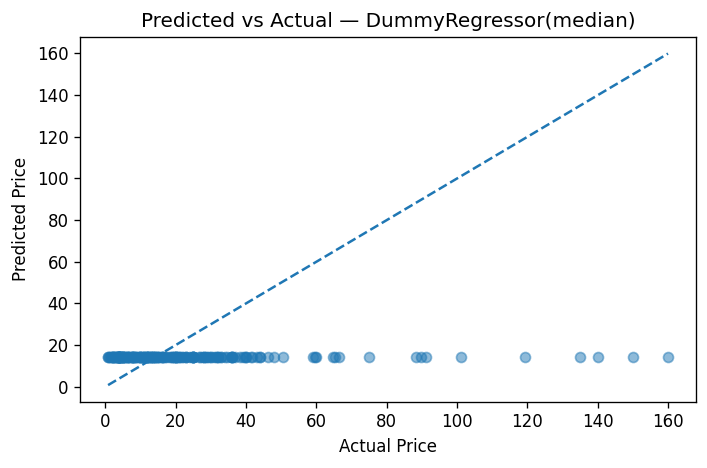

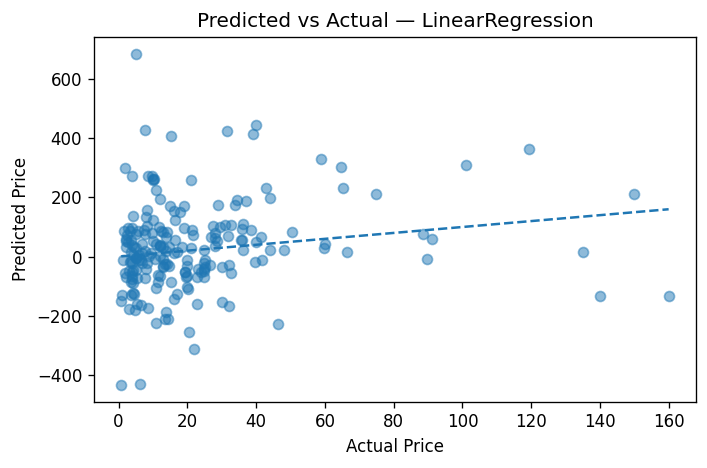

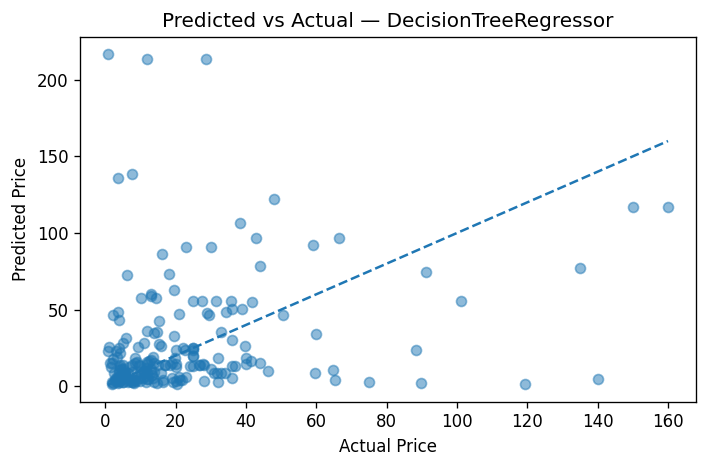

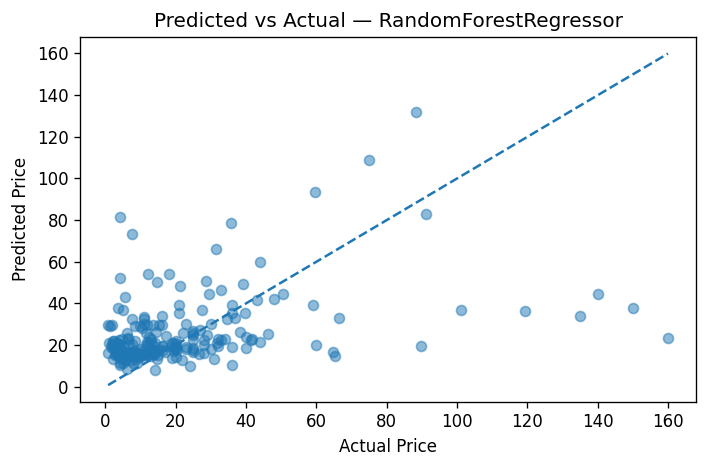

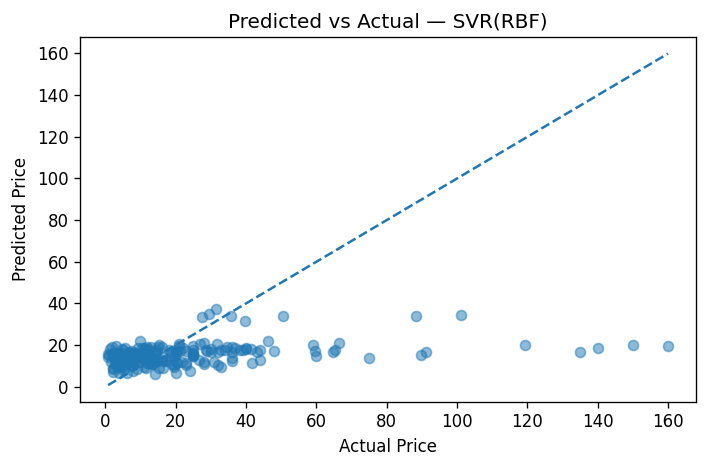

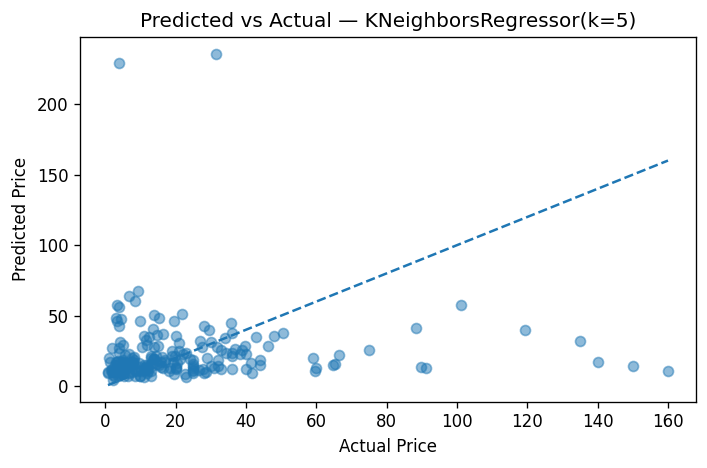

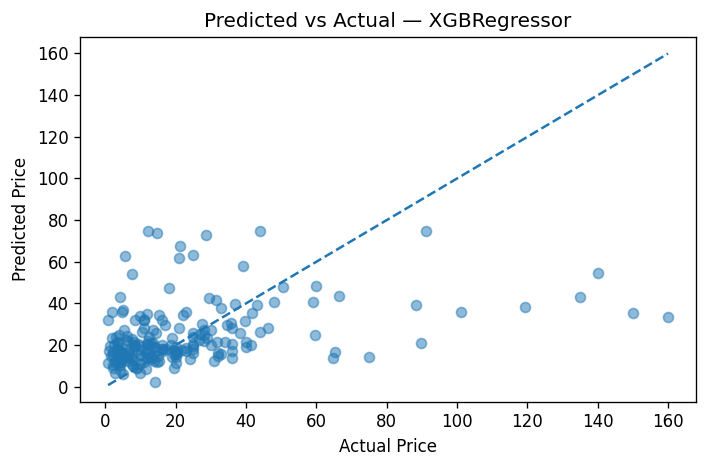

,Model,MAE,RMSE,R2
0,XGBRegressor,15.668203,24.754546,0.109713
1,RandomForestRegressor,16.209584,25.389434,0.063461
2,SVR(RBF),14.290325,25.698166,0.040546
3,DummyRegressor(median),15.418875,27.440323,-0.093952
4,KNeighborsRegressor(k=5),19.153937,35.262603,-0.806545
5,DecisionTreeRegressor,21.603450,39.054944,-1.216011
6,LinearRegression,104.966662,147.077317,-30.427609


In [32]:
# ==========================================
# Cell 8 — Train & Evaluate Regressors (Fused: Text + Image)
# ==========================================
from collections import OrderedDict

reg_models = OrderedDict({
    "DummyRegressor(median)": DummyRegressor(strategy="median"),
    "LinearRegression": LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=42),
    "RandomForestRegressor": RandomForestRegressor(
        n_estimators=300, max_depth=None, n_jobs=-1, random_state=42
    ),
    "SVR(RBF)": SVR(kernel="rbf", C=10.0, gamma="scale"),
    "KNeighborsRegressor(k=5)": KNeighborsRegressor(n_neighbors=5, weights="distance"),
})

if HAS_XGB:
    reg_models["XGBRegressor"] = XGBRegressor(
        n_estimators=400, max_depth=8, learning_rate=0.05, subsample=0.8,
        colsample_bytree=0.8, reg_lambda=1.0, random_state=42, n_jobs=-1
    )

reg_results = []

for name, model in reg_models.items():
    if name.startswith(("SVR", "KNeighborsRegressor")):
        model.fit(X_train_reg_dense, y_train_reg)
        preds = model.predict(X_test_reg_dense)
    else:
        model.fit(X_train_reg_sparse, y_train_reg)
        preds = model.predict(X_test_reg_sparse)

    mae  = mean_absolute_error(y_test_reg, preds)
    rmse = np.sqrt(mean_squared_error(y_test_reg, preds))
    r2   = r2_score(y_test_reg, preds)
    reg_results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2})

    plot_pred_vs_actual(
        y_true=y_test_reg, y_pred=preds,
        title=f"Predicted vs Actual — {name}",
        savepath=os.path.join(OUTDIR, f"reg_pred_vs_actual_{name}.png")
    )

reg_table = pd.DataFrame(reg_results).sort_values("RMSE").reset_index(drop=True)
display(reg_table)
reg_table.to_csv(os.path.join(OUTDIR, "regression_results.csv"), index=False)


In [34]:
# ==========================================
# Cell 9 — Helpers for Classification
# ==========================================
CLASS_NAMES = ["Budget", "Mid-Range", "Premium"]

def plot_confusion_matrix(cm, classes, title, savepath=None):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation="nearest")
    ax.figure.colorbar(im, ax=ax)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_yticklabels(classes)
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    ax.set_title(title)

    # Annotate cells
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], "d"),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    if savepath:
        plt.savefig(savepath)
    plt.show()

def plot_multiclass_roc_pr(y_true, y_proba, class_names, prefix=None):
    # One-vs-rest curves
    y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))

    # ROC
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Micro-average ROC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Macro-average ROC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(class_names)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(class_names)

    plt.figure()
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC={roc_auc[i]:.3f})")
    plt.plot(fpr["micro"], tpr["micro"], linestyle="--", label=f"Micro (AUC={roc_auc['micro']:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (OvR)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    if prefix:
        plt.savefig(f"{prefix}_roc.png")
    plt.show()

    # Precision-Recall
    precision, recall, avg_prec = {}, {}, {}
    for i in range(len(class_names)):
        precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_proba[:, i])
        avg_prec[i] = average_precision_score(y_true_bin[:, i], y_proba[:, i])

    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true_bin.ravel(), y_proba.ravel())
    avg_prec["micro"] = average_precision_score(y_true_bin, y_proba, average="micro")

    plt.figure()
    for i in range(len(class_names)):
        plt.plot(recall[i], precision[i], label=f"{class_names[i]} (AP={avg_prec[i]:.3f})")
    plt.plot(recall["micro"], precision["micro"], linestyle="--", label=f"Micro (AP={avg_prec['micro']:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curves (OvR)")
    plt.legend(loc="lower left")
    plt.tight_layout()
    if prefix:
        plt.savefig(f"{prefix}_pr.png")
    plt.show()


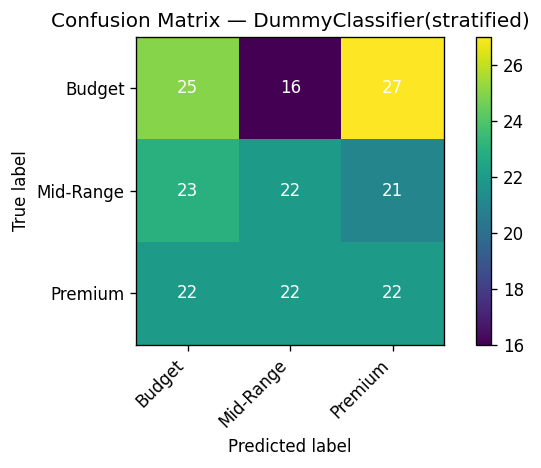

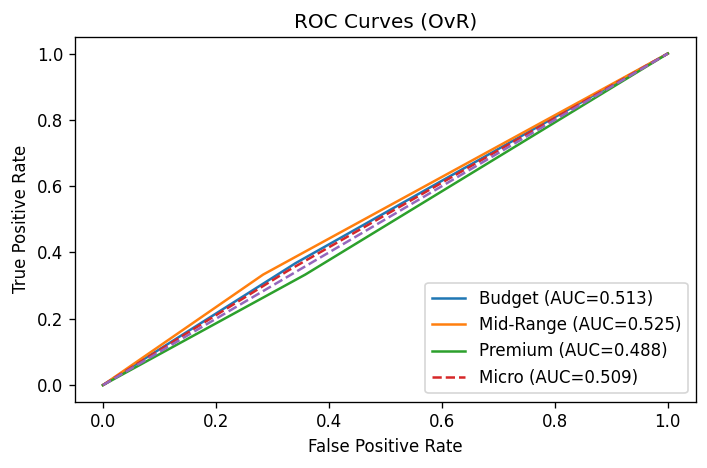

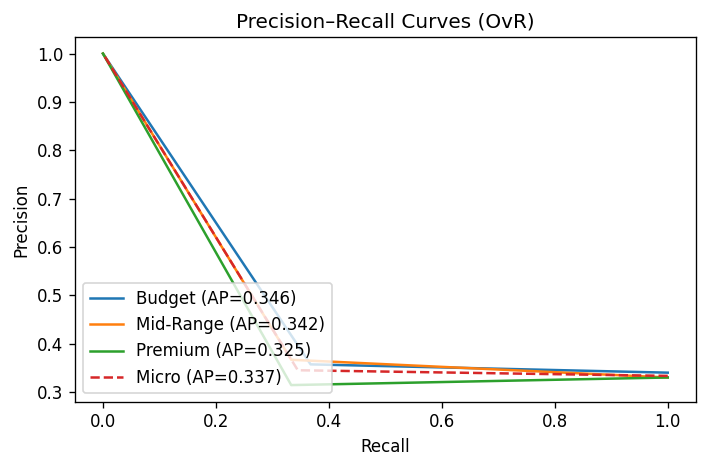

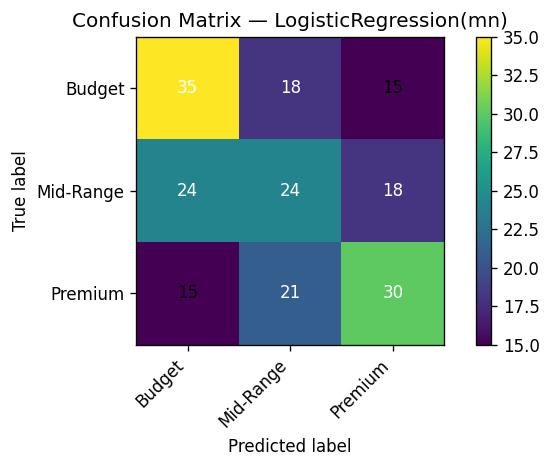

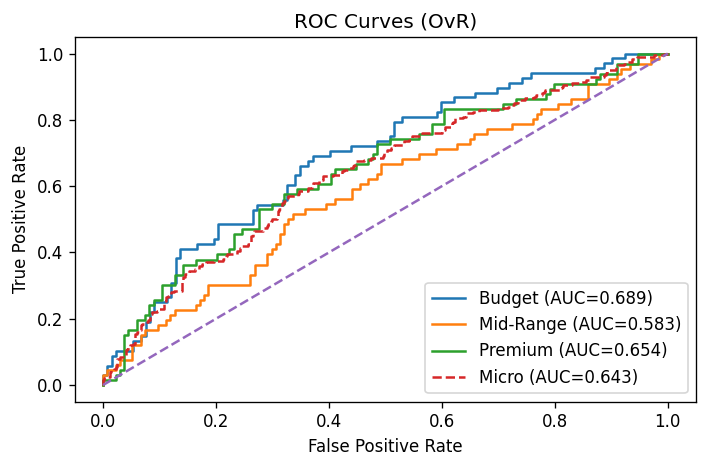

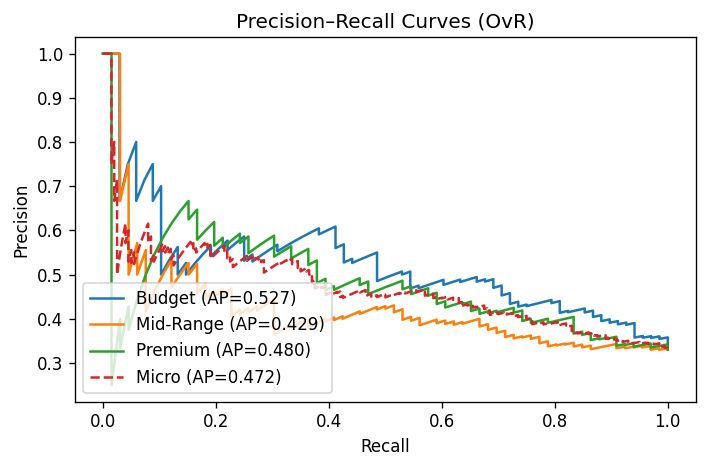

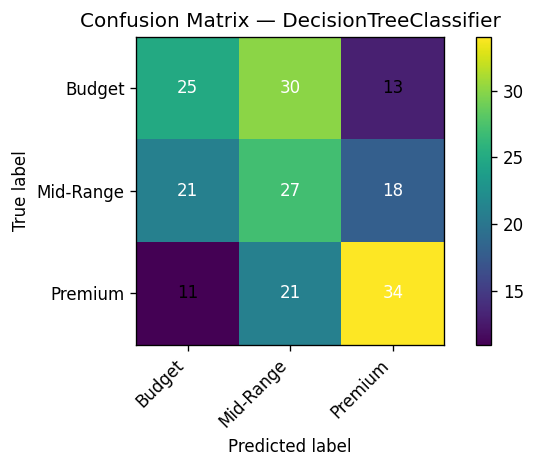

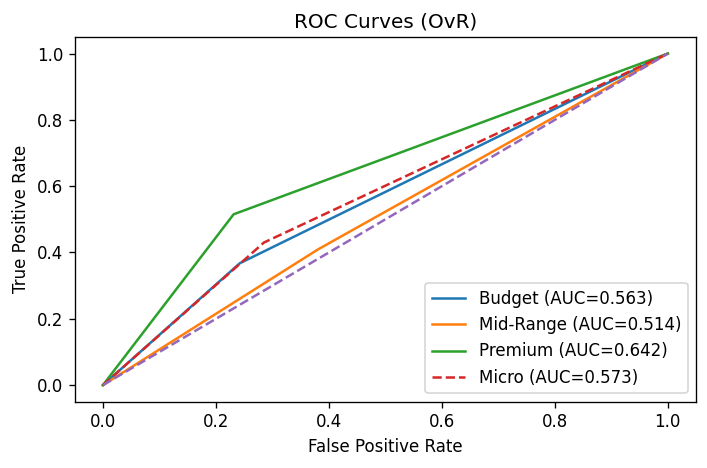

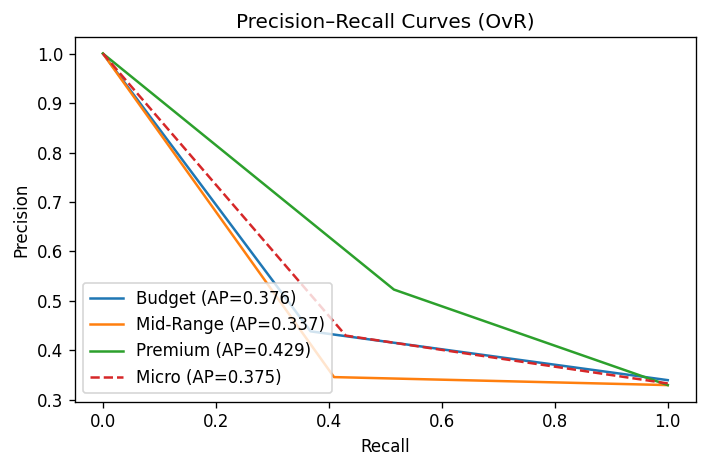

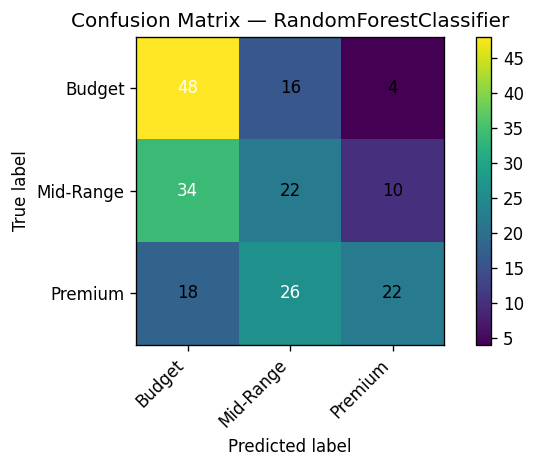

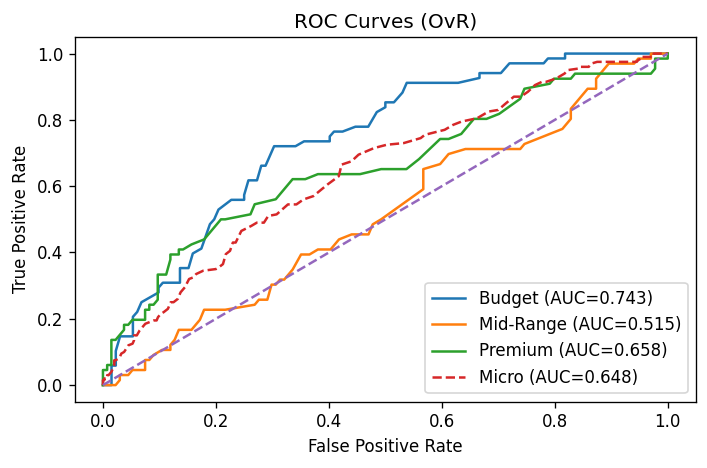

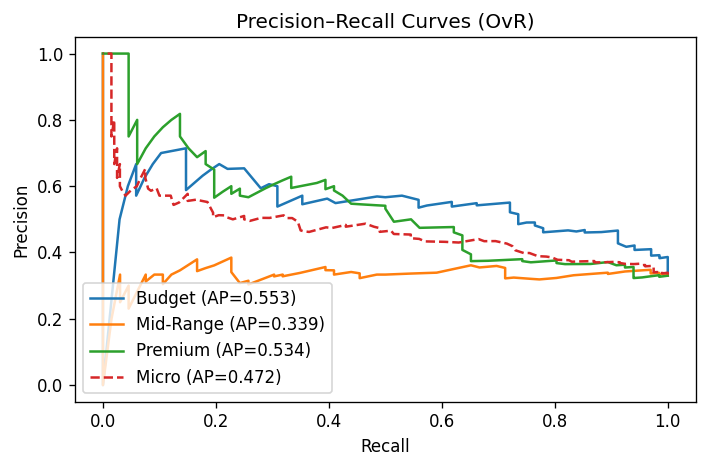

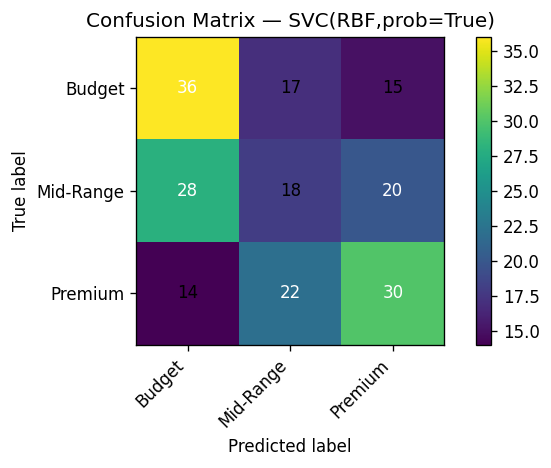

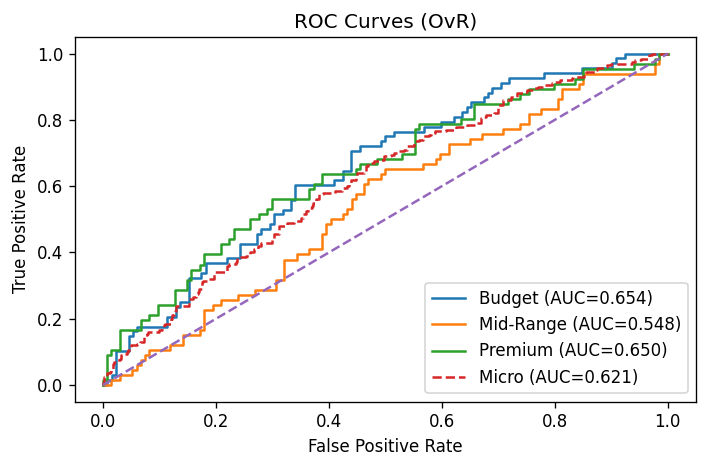

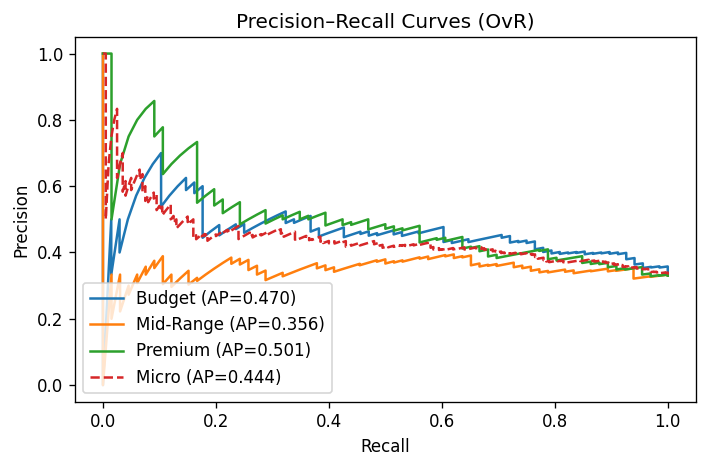

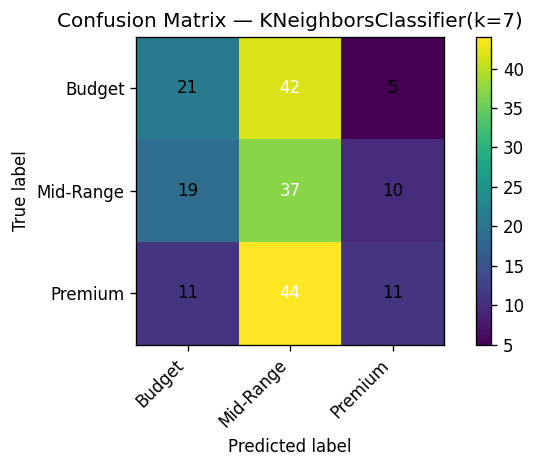

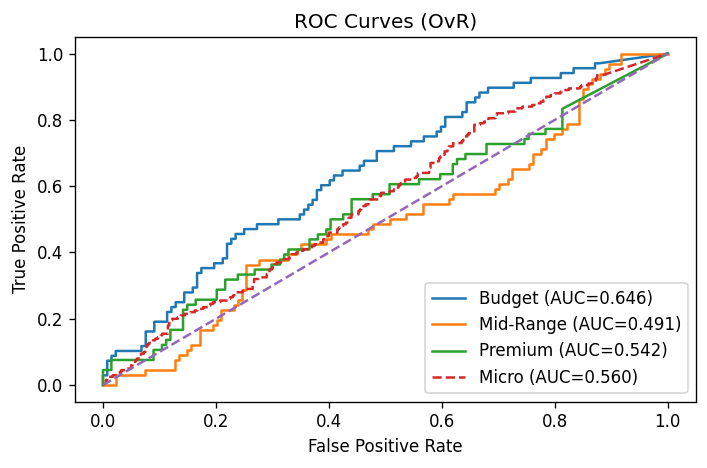

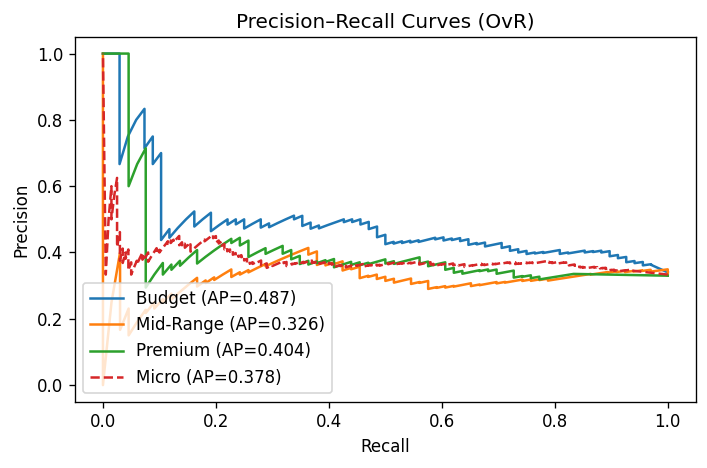

ValueError: Negative values in data passed to MultinomialNB (input X).

In [35]:
# ==========================================
# Cell 10 — Train & Evaluate Classifiers (Fused: Text + Image)
# ==========================================
from collections import OrderedDict

clf_models = OrderedDict({
    "DummyClassifier(stratified)": DummyClassifier(strategy="stratified", random_state=42),
    "LogisticRegression(mn)": LogisticRegression(max_iter=200, multi_class="multinomial", solver="saga", n_jobs=-1),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=300, max_depth=None, n_jobs=-1, random_state=42),
    "SVC(RBF,prob=True)": SVC(kernel="rbf", probability=True, C=5.0, gamma="scale", random_state=42),
    "KNeighborsClassifier(k=7)": KNeighborsClassifier(n_neighbors=7, weights="distance"),
    "MultinomialNB": MultinomialNB(alpha=0.5),
})

if HAS_XGB:
    clf_models["XGBClassifier"] = XGBClassifier(
        n_estimators=400, max_depth=8, learning_rate=0.05, subsample=0.8,
        colsample_bytree=0.8, reg_lambda=1.0, random_state=42, n_jobs=-1,
        objective="multi:softprob", num_class=3
    )

clf_results = []

for name, model in clf_models.items():
    # Dense-only models (SVC/KNN) use dense fused features
    if name.startswith(("SVC", "KNeighborsClassifier")):
        model.fit(X_train_clf_dense, y_train_clf)
        y_pred = model.predict(X_test_clf_dense)

        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test_clf_dense)
        else:
            df_scores = model.decision_function(X_test_clf_dense)
            if df_scores.ndim == 1:
                df_scores = np.vstack([-df_scores, df_scores]).T
            e_x = np.exp(df_scores - np.max(df_scores, axis=1, keepdims=True))
            y_proba = e_x / e_x.sum(axis=1, keepdims=True)
    else:
        # Sparse-friendly path (text sparse + image as CSR)
        model.fit(X_train_clf_sparse, y_train_clf)
        y_pred = model.predict(X_test_clf_sparse)
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test_clf_sparse)
        elif hasattr(model, "decision_function"):
            df_scores = model.decision_function(X_test_clf_sparse)
            if df_scores.ndim == 1:
                df_scores = np.vstack([-df_scores, df_scores]).T
            e_x = np.exp(df_scores - np.max(df_scores, axis=1, keepdims=True))
            y_proba = e_x / e_x.sum(axis=1, keepdims=True)
        else:
            y_proba = np.eye(len(CLASS_NAMES))[y_pred]

    acc = accuracy_score(y_test_clf, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test_clf, y_pred, average="macro", zero_division=0)
    clf_results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision (macro)": prec,
        "Recall (macro)": rec,
        "F1 (macro)": f1
    })

    cm = confusion_matrix(y_test_clf, y_pred, labels=[0, 1, 2])
    plot_confusion_matrix(
        cm,
        classes=CLASS_NAMES,
        title=f"Confusion Matrix — {name}",
        savepath=os.path.join(OUTDIR, f"clf_confusion_matrix_{name}.png")
    )

    plot_multiclass_roc_pr(
        y_true=y_test_clf,
        y_proba=y_proba,
        class_names=CLASS_NAMES,
        prefix=os.path.join(OUTDIR, f"clf_{name}")
    )

clf_table = pd.DataFrame(clf_results).sort_values("F1 (macro)", ascending=False).reset_index(drop=True)
display(clf_table)
clf_table.to_csv(os.path.join(OUTDIR, "classification_results.csv"), index=False)


In [36]:
# ==========================================
# Cell 11 — Optional Unsupervised Baselines
# ==========================================
# Evaluate how well clustering on TF-IDF text matches price classes.
# Map cluster IDs → class IDs via Hungarian algorithm to compute Accuracy/F1.

unsup_results = []

# KMeans (3 clusters)
kmeans_pipe = Pipeline([
    ("features", features_clf),
    ("kmeans", KMeans(n_clusters=3, random_state=42, n_init=10))
])
kmeans_pipe.fit(X_text)
kmeans_labels = kmeans_pipe.named_steps["kmeans"].labels_

cm = confusion_matrix(df["price_class"].values, kmeans_labels, labels=[0,1,2])
cost = -cm
row_ind, col_ind = linear_sum_assignment(cost)
kmeans_map = {col_ind[i]: row_ind[i] for i in range(len(row_ind))}
kmeans_mapped = np.vectorize(kmeans_map.get)(kmeans_labels)

acc = accuracy_score(df["price_class"].values, kmeans_mapped)
prec, rec, f1, _ = precision_recall_fscore_support(df["price_class"].values, kmeans_mapped, average="macro", zero_division=0)
unsup_results.append({"Model": "KMeans(3)", "Accuracy": acc, "Precision (macro)": prec, "Recall (macro)": rec, "F1 (macro)": f1})

# GMM (3 components) on dense features
gmm_pipe = Pipeline([
    ("features", features_clf),
    ("to_dense", FunctionTransformer(lambda X: X.toarray(), accept_sparse=True)),
    ("gmm", GaussianMixture(n_components=3, covariance_type="diag", random_state=42))
])
gmm_pipe.fit(X_text)
dense_feats = gmm_pipe.named_steps["to_dense"].transform(gmm_pipe.named_steps["features"].fit_transform(X_text))
gmm_labels = gmm_pipe.named_steps["gmm"].predict(dense_feats)

cm2 = confusion_matrix(df["price_class"].values, gmm_labels, labels=[0,1,2])
cost2 = -cm2
row_ind2, col_ind2 = linear_sum_assignment(cost2)
gmm_map = {col_ind2[i]: row_ind2[i] for i in range(len(row_ind2))}
gmm_mapped = np.vectorize(gmm_map.get)(gmm_labels)

acc2 = accuracy_score(df["price_class"].values, gmm_mapped)
prec2, rec2, f12, _ = precision_recall_fscore_support(df["price_class"].values, gmm_mapped, average="macro", zero_division=0)
unsup_results.append({"Model": "GMM(3)", "Accuracy": acc2, "Precision (macro)": prec2, "Recall (macro)": rec2, "F1 (macro)": f12})

unsup_table = pd.DataFrame(unsup_results).sort_values("F1 (macro)", ascending=False).reset_index(drop=True)
display(unsup_table)
unsup_table.to_csv(os.path.join(OUTDIR, "unsupervised_results.csv"), index=False)


,Model,Accuracy,Precision (macro),Recall (macro),F1 (macro)
0,GMM(3),0.428,0.502912,0.428239,0.398044
1,KMeans(3),0.409,0.503341,0.409802,0.374355


In [45]:
# ==========================================
# Cell — Full-dataset metrics (price)
# ==========================================
# Computes descriptive statistics on the FULL dataset (df)
# Assumes df has a numeric column: df["price"]

import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

def describe_price(series: pd.Series) -> pd.Series:
    x = pd.to_numeric(series, errors="coerce").dropna().astype(float)
    out = {}
    out["count"] = x.size
    out["mean"] = x.mean()
    out["median"] = x.median()
    out["variance"] = x.var(ddof=1)
    out["std"] = x.std(ddof=1)
    out["min"] = x.min()
    out["max"] = x.max()
    out["range"] = out["max"] - out["min"]
    q1, q3 = x.quantile(0.25), x.quantile(0.75)
    out["Q1"] = q1
    out["Q3"] = q3
    out["IQR"] = q3 - q1
    out["skewness"] = skew(x, bias=False, nan_policy="omit")
    out["kurtosis"] = kurtosis(x, fisher=True, bias=False, nan_policy="omit")  # excess kurtosis
    # Percentiles
    for p in [10, 25, 50, 75, 90, 95, 99]:
        out[f"p{p}"] = np.percentile(x, p)
    # Coefficient of Variation
    out["CV"] = out["std"] / out["mean"] if out["mean"] != 0 else np.nan
    return pd.Series(out)

full_price_stats = describe_price(df["price"])
display(full_price_stats.to_frame("full_dataset").T)

# Optional: save metrics for reference
out_metrics_path = os.path.join(OUTDIR, "full_dataset_price_metrics.csv")
full_price_stats.to_frame("value").to_csv(out_metrics_path)
print("Saved:", out_metrics_path)


,count,mean,median,variance,std,min,max,range,Q1,Q3,...,skewness,kurtosis,p10,p25,p50,p75,p90,p95,p99,CV
full_dataset,75000.0,23.647654,14.0,1114.019602,33.376932,0.13,2796.0,2795.87,6.795,28.625,...,13.601389,736.654508,3.565,6.795,14.0,28.625,52.301,75.711,145.2503,1.411427


Saved: results_nb/full_dataset_price_metrics.csv


In [48]:
# ==========================================
# Cell — Sample 10,000 rows matching full metrics
# ==========================================
# Strategy:
# 1) Stratified sampling by price quantile bins (default 100 bins; ~100 rows each).
# 2) Try multiple random seeds; pick the subset minimizing a composite error
#    across mean, std, skewness, kurtosis, and key percentiles.
# 3) Save as new_dataset.csv in OUTDIR.

import numpy as np
import pandas as pd

TARGET_N = 25_000          # desired subset size
N_BINS = 100                # number of quantile bins for stratification
N_TRIALS = 25               # number of random seeds to try and keep best
KEY_PCTS = [10, 25, 50, 75, 90, 95, 99]

# Guard: if dataset smaller than target, just use all
if len(df) <= TARGET_N:
    subset_df = df.sample(frac=1.0, random_state=42)
    print(f"Dataset has only {len(df)} rows (<= {TARGET_N}). Using all rows.")
else:
    # Work on a clean frame with required columns
    work = df.dropna(subset=["price"]).copy()
    work["price"] = pd.to_numeric(work["price"], errors="coerce")
    work = work.dropna(subset=["price"])

    # Build quantile edges (ensure unique edges to avoid empty bins)
    quantiles = np.linspace(0, 1, N_BINS + 1)
    edges = work["price"].quantile(quantiles).values
    # De-duplicate monotonically increasing edges
    edges = np.unique(edges)
    # If duplicates reduce the number of bins
    if edges.size < N_BINS + 1:
        print(f"Note: reduced effective bins from {N_BINS} to {edges.size-1} due to tied prices.")
    # Assign bins
    bins = pd.cut(work["price"], bins=edges, include_lowest=True, labels=False)
    work = work.loc[~bins.isna()].copy()
    work["qbin"] = bins.astype(int)

    # Target per-bin counts roughly equal
    unique_bins = np.sort(work["qbin"].unique())
    B = unique_bins.size
    base = TARGET_N // B
    rem = TARGET_N - base * B
    target_per_bin = {b: base + (1 if i < rem else 0) for i, b in enumerate(unique_bins)}

    def composite_error(sample_stats: pd.Series, ref_stats: pd.Series) -> float:
        # Compare a set of metrics with scale normalization
        metrics = {
            "mean": 1.0,
            "std": 1.0,
            "skewness": 0.5,
            "kurtosis": 0.5,
        }
        err = 0.0
        for m, w in metrics.items():
            denom = abs(ref_stats[m]) + 1e-9
            err += w * abs(sample_stats[m] - ref_stats[m]) / denom
        # Percentiles: average relative error
        p_errs = []
        for p in KEY_PCTS:
            pm = f"p{p}"
            denom = abs(ref_stats[pm]) + 1e-9
            p_errs.append(abs(sample_stats[pm] - ref_stats[pm]) / denom)
        err += np.mean(p_errs)
        return float(err)

    best_err = np.inf
    best_subset = None

    # Precompute per-bin indices
    bin_to_idx = {b: work.index[work["qbin"] == b].values for b in unique_bins}

    for trial in range(N_TRIALS):
        rng = np.random.default_rng(1000 + trial)
        pick_idx = []
        for b in unique_bins:
            idx = bin_to_idx[b]
            k = min(target_per_bin[b], idx.size)
            # Sample without replacement (if bin too small, take all)
            choose = rng.choice(idx, size=k, replace=False)
            pick_idx.append(choose)
        pick_idx = np.concatenate(pick_idx)
        # Ensure exact size (occasionally sum could be < TARGET_N due to small bins)
        if pick_idx.size > TARGET_N:
            pick_idx = rng.choice(pick_idx, size=TARGET_N, replace=False)
        elif pick_idx.size < TARGET_N:
            # Top up from whole dataset randomly (rare)
            remaining = work.index.difference(pick_idx)
            topup = rng.choice(remaining, size=TARGET_N - pick_idx.size, replace=False)
            pick_idx = np.concatenate([pick_idx, topup])

        sample_df = work.loc[pick_idx].copy()
        sample_stats = describe_price(sample_df["price"])
        err = composite_error(sample_stats, full_price_stats)

        if err < best_err:
            best_err = err
            best_subset = sample_df

    subset_df = best_subset.sort_index()
    print(f"Selected subset with composite error: {best_err:.6f} (bins={B}, trials={N_TRIALS})")

# Compare metrics side-by-side
subset_stats = describe_price(subset_df["price"])
compare = pd.concat(
    [full_price_stats.rename("Full (75k)"), subset_stats.rename("Sample (25k)")],
    axis=1
)
display(compare)

# Save new dataset
new_path = os.path.join(OUTDIR, "new_dataset25k.csv")
subset_df.to_csv(new_path, index=False)
print("Saved subset to:", new_path)


Selected subset with composite error: 0.544779 (bins=100, trials=25)


,Full (75k),Sample (25k)
count,75000.000000,25000.000000
mean,23.647654,23.855371
median,14.000000,14.200000
variance,1114.019602,1147.628436
std,33.376932,33.876665
min,0.130000,0.360000
max,2796.000000,1280.000000
range,2795.870000,1279.640000
Q1,6.795000,6.715000
Q3,28.625000,28.950000


Saved subset to: results_nb/new_dataset25k.csv
